## Using R to investigate pairwise FST and nucleotide diversity  
Code adapted slightly from [Max Winston's scripts](https://github.com/mewinsto/Fst)  
This is just exploring one pair of populations. Will write up another notebook with looking at overall Fst and PCA in Adegenet.

An R script with this code can be found at my github [GBS_FST_Pi.R](https://raw.githubusercontent.com/ksil91/Scripts/master/FST/GBS_FST_Pi.R)

Requires: .geno file and .ind file containing 1 pair of populations. See [GBS_File_Conversions notebook](https://github.com/ksil91/2016_Notebook/blob/master/GBS_File_Conversions.ipynb) for code on how to get these files from a Structure (.str) formatted file.

In [16]:
setwd("~/Projects/Ostrea")
library("ggplot2")

In [3]:
## Read in .geno file
geno_data = scan("over10k-min75H32u_Barkeley_Sound_Conchaphila.geno",what = "character")
L = length(geno_data)
S = nchar(geno_data[[1]])
geno_matrix = matrix(data = NA, nrow = S, ncol = L)
for (i in 1:L){
    genostring = strsplit(geno_data[[i]], split="")
    for (j in 1:S){
        geno_matrix[j,i] = as.numeric(genostring[[1]][j])
    }
}
geno_matrix[geno_matrix == 9] = NA

##Read in .ind file in order to get population assignment for genotypes.
testpop = read.table("over10k-min75H32u_Barkeley_Sound_Conchaphila.ind",header=FALSE)
test_vector = testpop$V2

test_sub = {}
for (i in 1:S){
    if (test_vector[i] == 1){
        test_sub = c(test_sub,i)
    }
}
## Creates a null vector, where individuals are randomly assigned to the 2 populations.
null_vector = sample(c(rep(1,sum(test_vector)),rep(0,S-sum(test_vector))),size=S)
null_sub = {}
for (i in 1:S){
    if (null_vector[i] == 1){
        null_sub = c(null_sub,i)
    }
}

In [5]:
## Number of loci
L

[1] 1791

In [6]:
##THIS MODULE CALCULATES PI (NUCLEOTIDE DIVERSITY) FOR EACH LOCUS AND WRITES TO A FILE
## Note that this is pi when considering individuals from just 2 populations. Will need to adapt to get pi from 
## entire dataset.
pi = {}
for (i in 1:L){
    locus = {}
    locus = geno_matrix[,i]
    locus = locus[!is.na(locus)]
    if(length(locus) >= 2){
        locus_sum = 0
        for (j in 2:length(locus)){
            jcount = j - 1
            for (k in 1:jcount){
                diff = 0
                diff = abs(locus[j]-locus[k])
                locus_sum = locus_sum + diff
            }
        }
        locus_sum = (2*locus_sum)/(length(locus)^2) 
        pi[i] = locus_sum
    }
    else{
        pi[i] = NA
    }
}

write(pi,file="over10k-min75H32u_Barkeley_Sound_Conchaphila.pi",ncol = 1)

In [7]:
##THIS MODULE CALCULATES FREQUENCIES AND FST FOR TEST
#Counts and mean frequencies of alleles
geno_means = vector(mode = "numeric", length = L)
geno_cover = vector(mode = "numeric", length = L)
geno_cover_p1 = vector(mode = "numeric", length = length(test_sub))
geno_cover_p2 = vector(mode = "numeric", length = L - length(test_sub))
for (i in 1:L){
    geno_means[i] = mean(geno_matrix[,i],na.rm=TRUE)/2
}
for (i in 1:L){
    geno_cover[i] = sum(!is.na(geno_matrix[,i]))
    geno_cover_p1[i] = sum(!is.na(geno_matrix[test_sub,i]))
    geno_cover_p2[i] = sum(!is.na(geno_matrix[-test_sub,i]))
}

#Use test_sub to look at Fst values
pop_1 = {}
pop_2 = {}
pop_mean = {}
FST = {}
for (i in 1:L){
    pop_1[i] = mean(geno_matrix[test_sub,i],na.rm=TRUE)/2
    pop_2[i] = mean(geno_matrix[-test_sub,i],na.rm=TRUE)/2
    #  pop_mean[i] = (pop_1[i] + pop_2[i])/2
    FST[i] = (geno_cover_p1[i]*(abs(geno_means[i] - pop_1[i])^2) + geno_cover_p2[i]*abs(geno_means[i] - pop_2[i])^2)/(geno_cover[i]*geno_means[i]*(1 - geno_means[i]))
}

FST = abs(FST)

##WRITE FST TO FILE
write(FST,file="over10k-min75H32u_Barkeley_Sound_Conchaphila.fst",ncolumns=1)
write(geno_cover,file="over10k-min75H32u_Barkeley_Sound_Conchaphila.geno_cover",ncolumns=1)

In [8]:
##THIS MODULE CALCULATES FREQUENCIES AND FST FOR NULL
#Counts and mean frequencies of alleles
geno_cover_p1_N = vector(mode = "numeric", length = length(null_sub))
geno_cover_p2_N = vector(mode = "numeric", length = L - length(null_sub))

for (i in 1:L){
    geno_cover[i] = sum(!is.na(geno_matrix[,i]))
    geno_cover_p1_N[i] = sum(!is.na(geno_matrix[null_sub,i]))
    geno_cover_p2_N[i] = sum(!is.na(geno_matrix[-null_sub,i]))
}

#Use null_sub to look at Fst values
pop_1_N = {}
pop_2_N = {}
pop_mean = {}
FST_N = {}
for (i in 1:L){
    pop_1_N[i] = mean(geno_matrix[null_sub,i],na.rm=TRUE)/2
    pop_2_N[i] = mean(geno_matrix[-null_sub,i],na.rm=TRUE)/2
    #  pop_mean[i] = (pop_1[i] + pop_2[i])/2
    FST_N[i] = (geno_cover_p1_N[i]*(abs(geno_means[i] - pop_1_N[i])^2) + geno_cover_p2_N[i]*abs(geno_means[i] - pop_2_N[i])^2)/(geno_cover[i]*geno_means[i]*(1 - geno_means[i]))
}

FST_N = abs(FST_N)

#WRITE FST TO FILE
write(FST_N,file="over10k-min75H32u_Barkeley_Sound_Conchaphila.fst_null",ncolumns=1)

In [9]:
##THIS MODULE CALCULATES major allele frequency (AF) FOR EACH LOCUS
af = {}
for (i in 1:L){
    L_maf = sum(!is.na(geno_matrix[,i]))
    L_sum = sum(geno_matrix[,i],na.rm=TRUE)
    af[i] = L_sum/(2*L_maf)
}

#Converts AF to minor allele frequency (MAF)
maf = {}
for (i in 1:L){
    if (!is.na(af[i])){
        if (af[i] > 0.5){
            maf[i] = 1 - af[i]
        } else{
            maf[i] = af[i]
        }
    }
}

#WRITE MAF and AF TO FILE
write(maf,file="over10k-min75H32u_Barkeley_Sound_Conchaphila.maf", ncolumns=1)
write(af, file="over10k-min75H32u_Barkeley_Sound_Conchaphila.af", ncolumns=1)

In [10]:
##THIS MODULE CALCULATES H-W EQUILIBRIUM FOR EACH LOCUS
HW_chi = {}
for (i in 1:L){
    L_maf = sum(!is.na(geno_matrix[,i]))
    p = af[i]
    q = 1 - p
    exp_pp = L_maf*(p^2)
    exp_pq = L_maf*(2*p*q)
    exp_qq = L_maf*(q^2)
    act_pp = sum(geno_matrix[,i] == 2,na.rm=TRUE)
    act_pq = sum(geno_matrix[,i] == 1,na.rm=TRUE)
    act_qq = sum(geno_matrix[,i] == 0,na.rm=TRUE)
    HW_chi[i] = ((act_pp - exp_pp)^2/exp_pp) + ((act_pq - exp_pq)^2/exp_pq) + ((act_qq - exp_qq)^2/exp_qq)
}
#WRITE HARDY-WEINBERG CHI-SQUARED STAT (CAN DERIVE p-values FROM THIS)
write(HW_chi,file="over10k-min75H32u_Barkeley_Sound_Conchaphila.HW",ncolumns=1)

In [13]:
#NUMBER OF INDIVIDUALS WITH SNP (FOR REMOVING SINGLETONS)
allele_class = {}
for (i in 1:L){
    allele_class[i] = maf[i]*geno_cover[i]
}

write(allele_class,file="over10k-min75H32u_Barkeley_Sound_Conchaphila.AC",ncolumns=1)

In [14]:
## Create matricx with all data
library(ggplot2)
pi = read.table("over10k-min75H32u_Barkeley_Sound_Conchaphila.pi")
f_null = read.table("over10k-min75H32u_Barkeley_Sound_Conchaphila.fst_null")
f_test = read.table("over10k-min75H32u_Barkeley_Sound_Conchaphila.fst")
cover_test = read.table("over10k-min75H32u_Barkeley_Sound_Conchaphila.geno_cover") 
af = read.table("over10k-min75H32u_Barkeley_Sound_Conchaphila.af")
HW_chi = read.table("over10k-min75H32u_Barkeley_Sound_Conchaphila.HW")
allele_class = read.table("over10k-min75H32u_Barkeley_Sound_Conchaphila.AC")

FST_data = cbind(f_null,f_test,cover_test,pi,af,HW_chi,allele_class)
names(FST_data) = c("F_null","F_test","Cover","Pi","AF","HW","AC")

In [15]:
##SUBSETS FST DATA INTO COVERAGE GROUPS
for (i in min(cover_test):max(cover_test)){
    name = paste("FST_data_cover_",i, sep = "")
    assign(name,subset(FST_data, cover_test == i))
}
#SUBSETS FST DATA INTO GROUPS WITH FST = 1.0
FST_data_HT = subset(FST_data, F_test == 1.0)
FST_data_HN = subset(FST_data, F_null == 1.0)

#SUBSETS FST DATA INTO GROUPS WITH FST < 0.1
FST_data_LT = subset(FST_data, F_test < 0.1)
FST_data_LN = subset(FST_data, F_null < 0.1)

#SUBSETS FST DATA INTO GROUPS WITH Pi > 0.8
Hi_Pi = subset(FST_data, Pi > 0.8)
Lo_Pi = subset(FST_data, Pi < 0.2)

Pi_cat = cut(FST_data$Pi,breaks=10)

#SUBSETS FST DATA TO EXCLUDE SINGLETONS (AC == 1)
FST_data_AC = subset(FST_data, allele_class > 1)
FST_data_AC_HT = subset(FST_data_AC, F_test == 1)

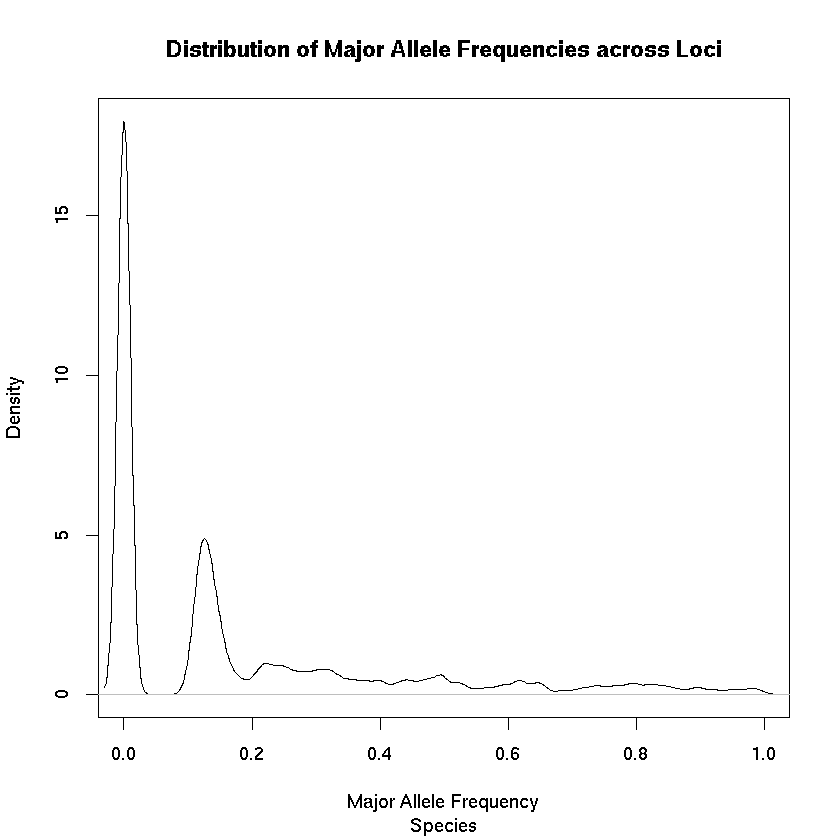

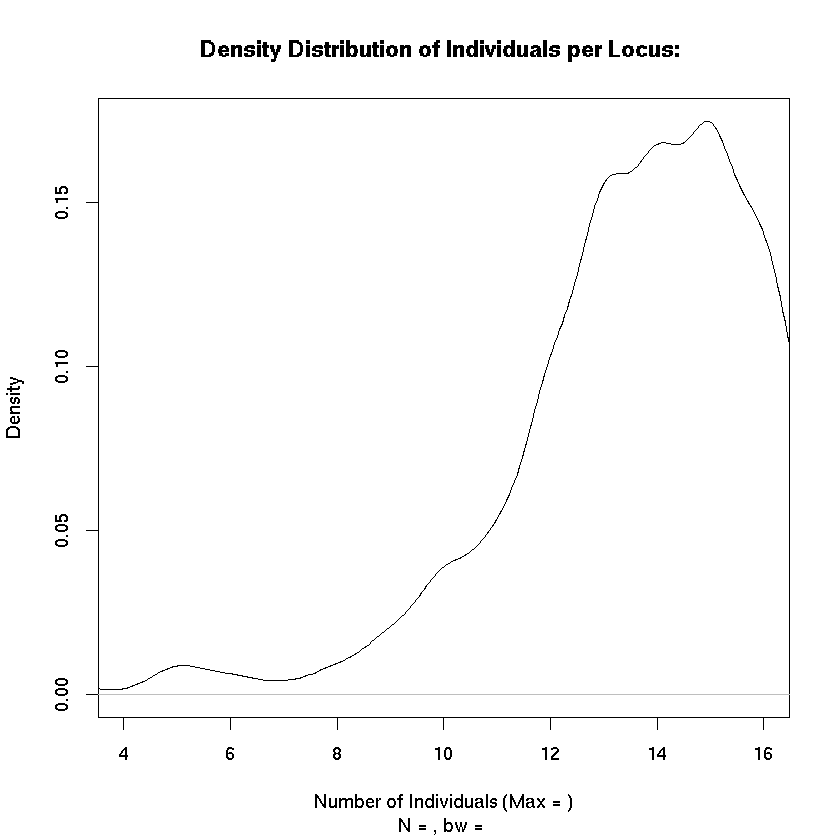

In [17]:
#Plot densities of these values
plot(density(FST_data$Pi,bw=0.01, na.rm=TRUE),xlim=c(0,1),main="Distribution of Major Allele Frequencies across Loci", xlab="Major Allele Frequency", sub="Species")
plot(density(FST_data$Cover,bw=0.5),xlim=c(4,16),main="Density Distribution of Individuals per Locus: ", xlab="Number of Individuals (Max = )",sub="N = , bw = ")


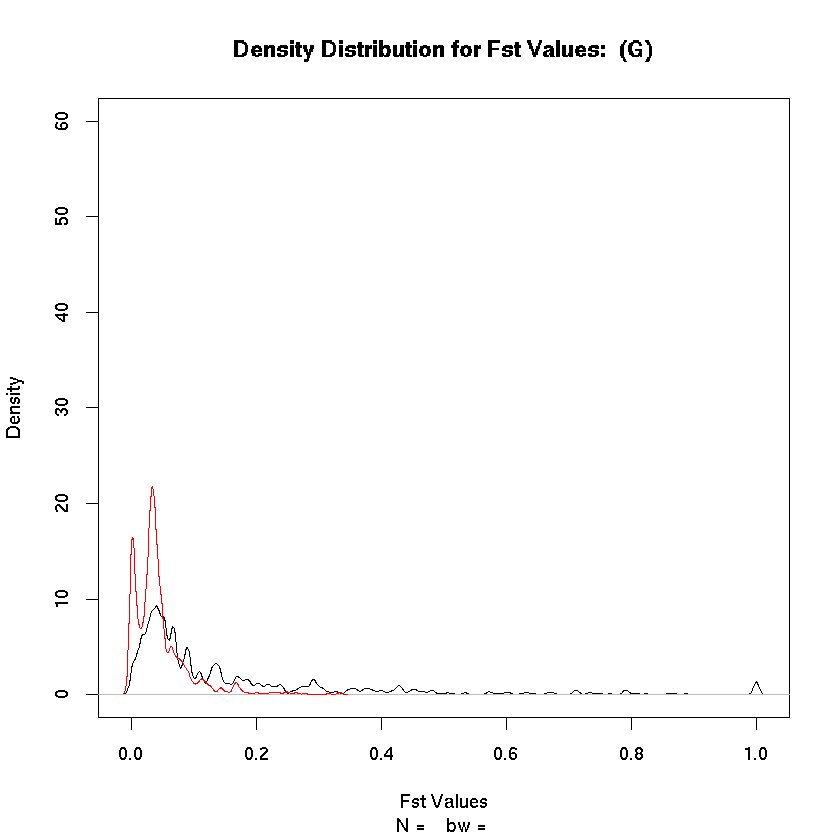

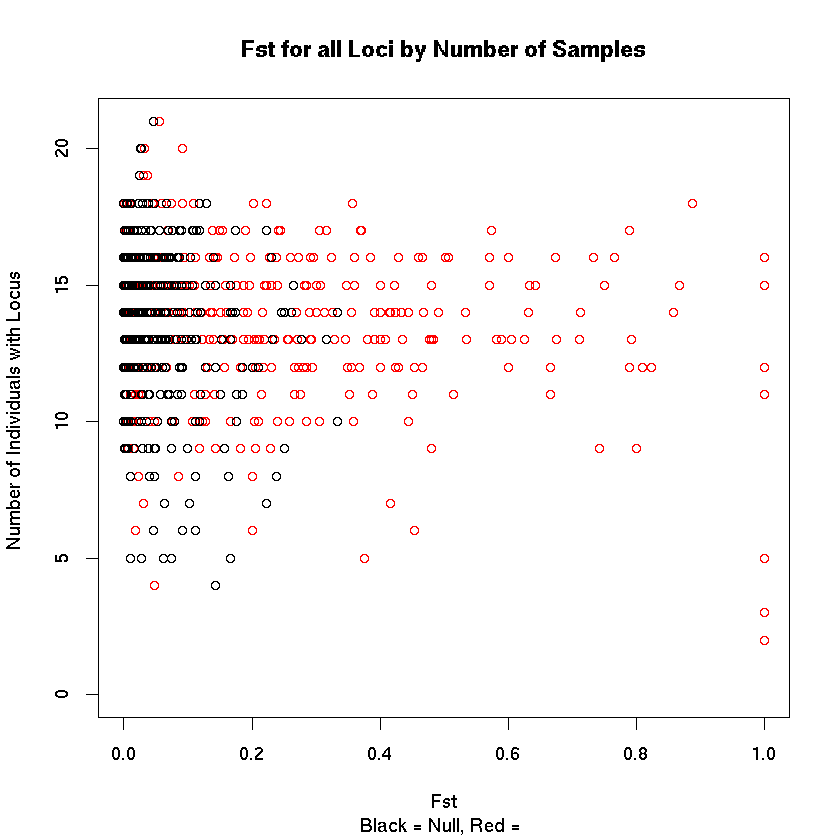

In [18]:
##PLOT FST AGAINST GENO_COVER
plot(density(FST_data$F_test,na.rm=TRUE,bw=.004),ylim=c(0,60),main="Density Distribution for Fst Values:  (G)",xlab="Fst Values", sub = "N =    bw = ")
lines(density(FST_data$F_null,na.rm=TRUE,bw=.004),col=2)

plot(FST_data$F_test,FST_data$Cover,col=2,main="Fst for all Loci by Number of Samples",xlab="Fst",ylab="Number of Individuals with Locus ",sub="Black = Null, Red = ")
points(FST_data$F_null,FST_data$Cover)

Warning message in min(x):
“no non-missing arguments to min; returning Inf”Warning message in max(x):
“no non-missing arguments to max; returning -Inf”

ERROR: Error in density.default(FST_data_HN$Cover, bw = 1): non-finite 'from'


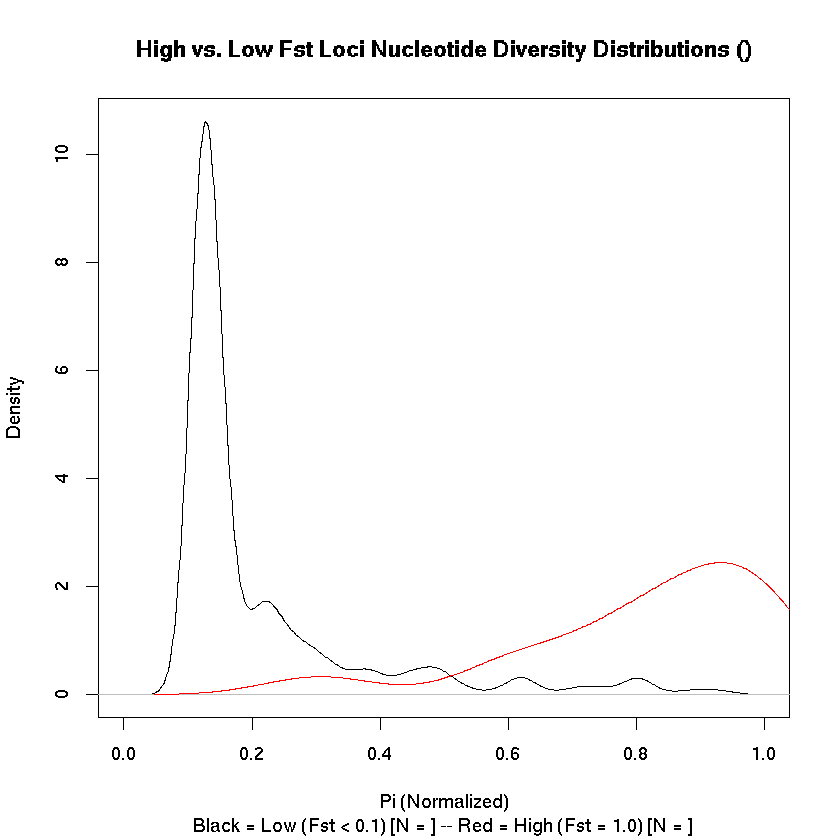

In [20]:
#PLOTS NUCLEOTIDE DIVERSITY FOR HIGH VS. LOW FST LOCI
plot(density(FST_data_LT$Pi),main="High vs. Low Fst Loci Nucleotide Diversity Distributions ()",xlim = c(0,1), 
     xlab="Pi (Normalized)",sub="Black = Low (Fst < 0.1) [N = ] -- Red = High (Fst = 1.0) [N = ]")
lines(density(FST_data_HT$Pi),col=2)

plot(density(FST_data_HN$Cover,bw=1),xlim=c(0,161))
lines(density(FST_data_HT$Cover),col=2)

Warning message in grid.Call.graphics(L_points, x$x, x$y, x$pch, x$size):
“semi-transparency is not supported on this device: reported only once per page”

Warning message:
“Removed 810 rows containing missing values (geom_point).”Warning message in grid.Call.graphics(L_points, x$x, x$y, x$pch, x$size):
“semi-transparency is not supported on this device: reported only once per page”

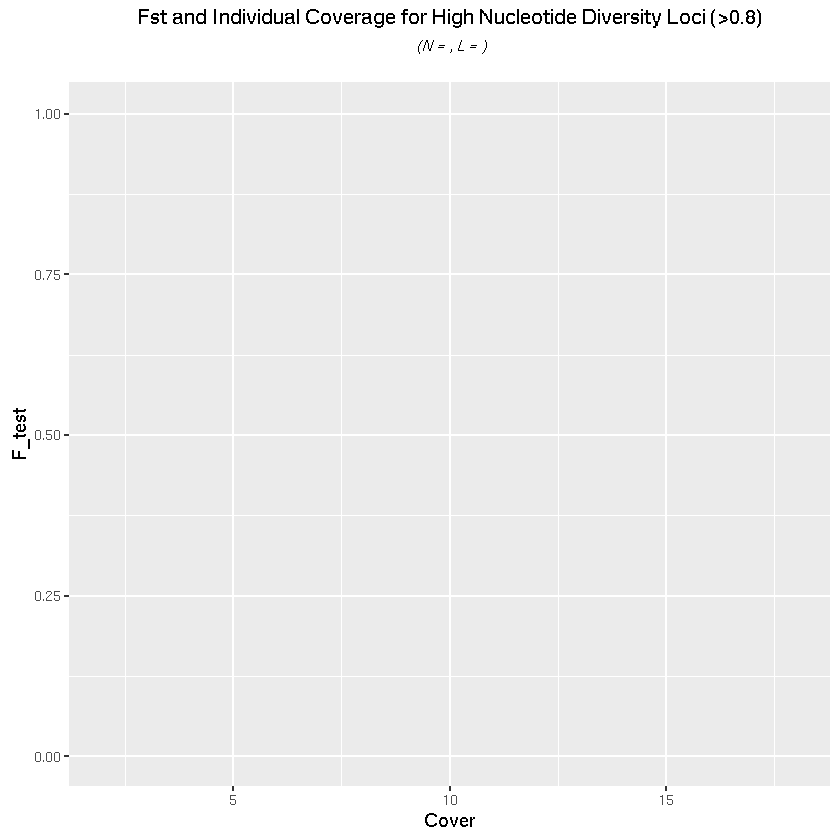

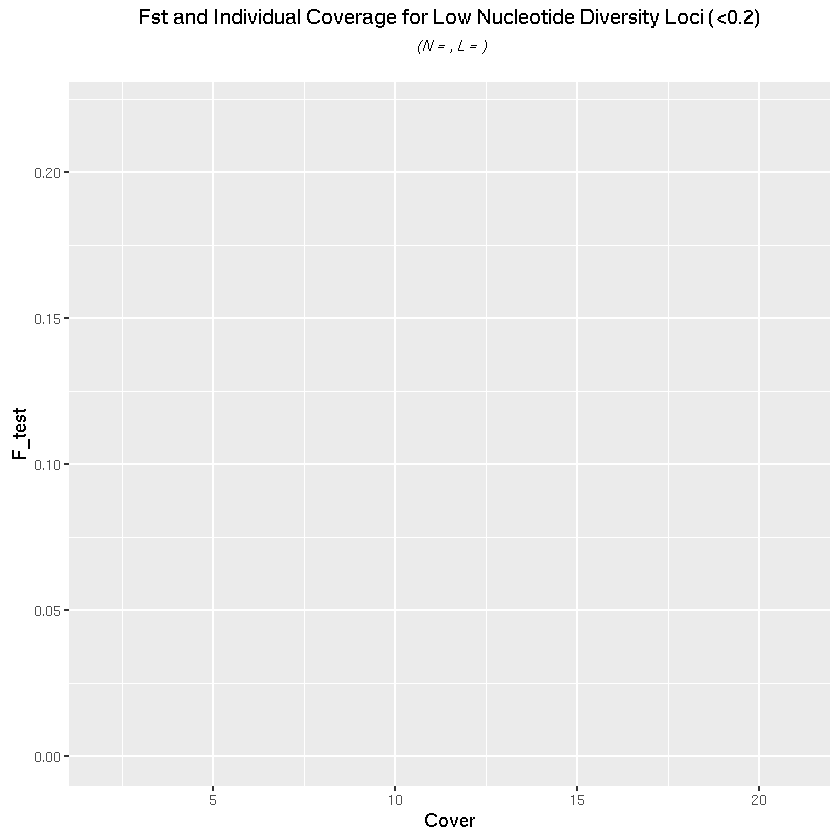

In [24]:
##Plots LOW DIVERSITY AND HIGH DIVERSITY LOCI
# Can't get this to work just yet...
HP = ggplot(Hi_Pi, aes(x = Cover, y = F_test))
HP + geom_point(alpha = 0.05) + ggtitle(expression(atop("Fst and Individual Coverage for High Nucleotide Diversity Loci (>0.8)", atop(italic(" (N = , L = )", "")))))

HPlow = ggplot(Lo_Pi, aes(x = Cover, y = F_test), na.rm=TRUE)
HPlow + geom_point(alpha = 0.05) + ggtitle(expression(atop("Fst and Individual Coverage for Low Nucleotide Diversity Loci (<0.2)", atop(italic(" (N = , L = )", "")))))


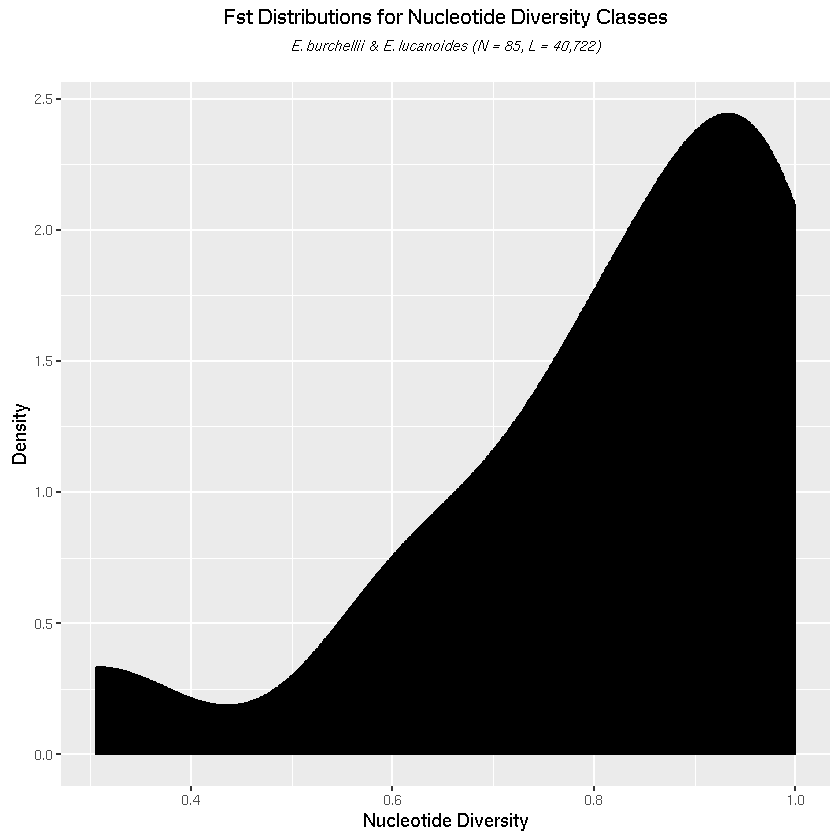

In [25]:
##PLOTS DENSITY DISTRIBUTION OF NUCLEOTIDE DIVERSITY FOR FST == 1.0
TOP_DENS = ggplot(FST_data_HT, aes(x = Pi))
TOP_DENS + geom_density(fill = "black") + ggtitle(expression(atop("Fst Distributions for Nucleotide Diversity Classes", atop(italic("E. burchellii & E. lucanoides (N = 85, L = 40,722)", ""))))) + labs(x = "Nucleotide Diversity", y = "Density")


Warning message:
“Removed 829 rows containing non-finite values (stat_boxplot).”

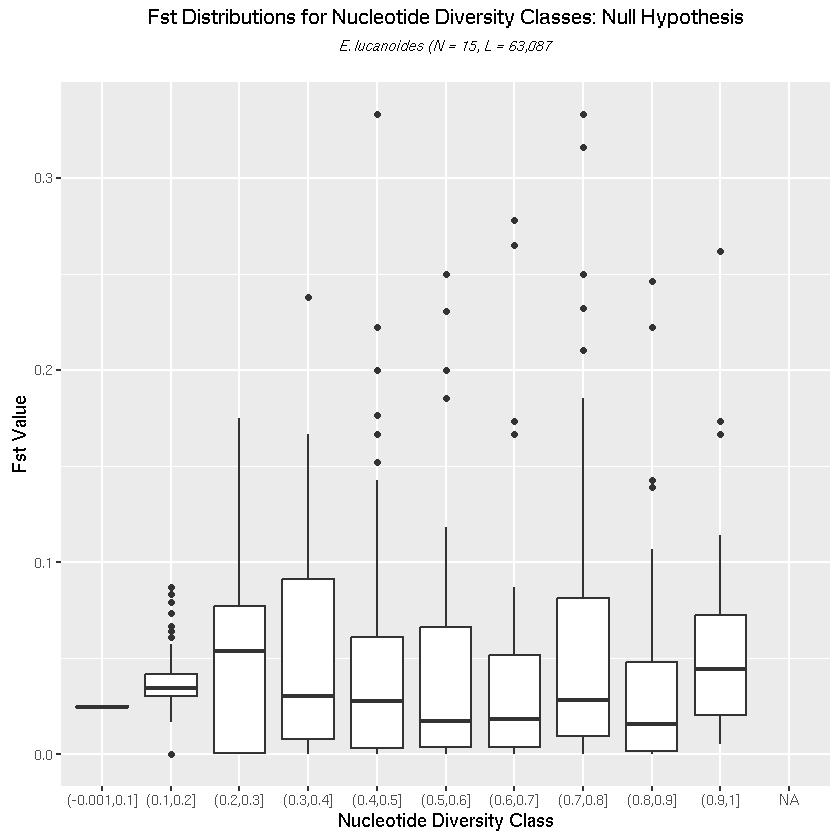

In [26]:
##GGPLOT NUCLEOTIDE DIVERSITY CLASSES AGAINST FST FOR NULL AND TEST
p = ggplot(FST_data, aes(factor(Pi_cat), F_null))

#p + geom_violin() + ggtitle(expression(atop("Fst Distributions for Nucleotide Diversity Classes",
#atop(italic("E. burchellii (N = 75, L = 168,518)", ""))))) + 
#labs(x = "Nucleotide Diversity Class", y = "Fst Value")

p + geom_boxplot() + ggtitle(expression(atop("Fst Distributions for Nucleotide Diversity Classes: Null Hypothesis", 
atop(italic("E. lucanoides (N = 15, L = 63,087", ""))))) + labs(x = "Nucleotide Diversity Class", y = "Fst Value")


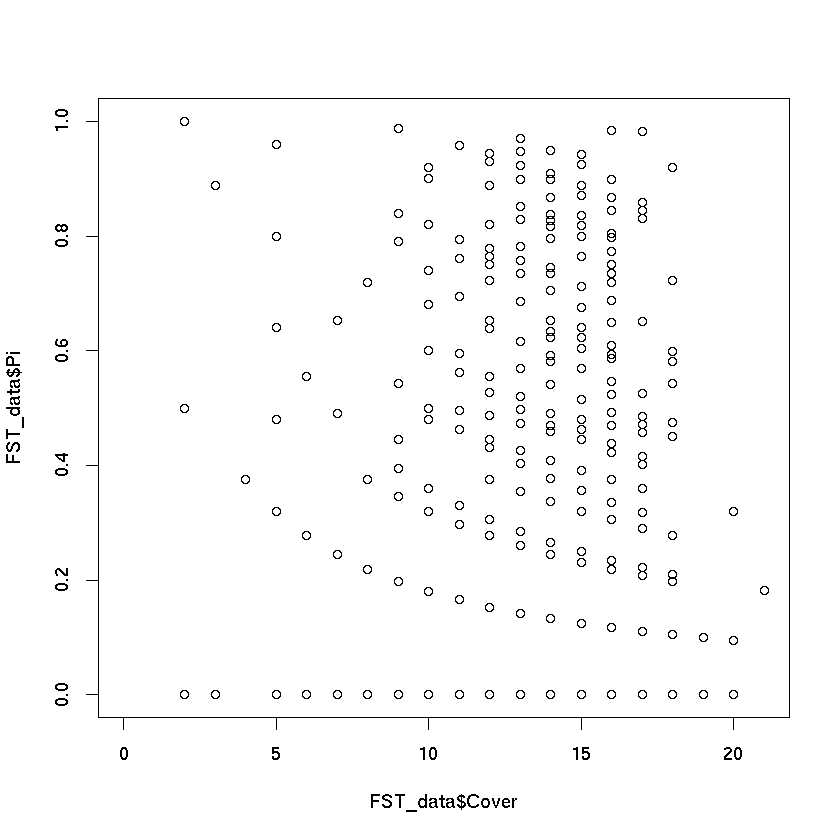

In [27]:
#Plots Pi against Coverage of Individuals
plot(FST_data$Cover,FST_data$Pi)